In [1]:
from utils.simulation.sim_utils import RandomSimulator
from utils.core.save_manager import SaveUtils
from utils.data_io import load_data
import os
from utils.eda.visualisation.general_viz import Visualisation
from utils.eda.correlation import CorrelationAnalyzer
import pandas as pd
from utils.simulation.decomposition import Decomposer
from utils.simulation.covariance_matrix import CovarianceMatrix
from utils.simulation.monte_carlo_simulator import MonteCarloSimulator

🧪 Simulating Unscaled Normally Distributed Data with Specified Skewness and Kurtosis

In [2]:
simulator = RandomSimulator(num_simulations=1000)
df = simulator.simulate_normal(num_variables=10, target_skew=0, target_kurt=3)

save_util = SaveUtils()
save_util.save_dataframe_to_csv(df,os.path.join(os.getcwd(), "data/output/simulated_normal.csv"), overwrite=True)

Data saved to c:\Data Science Projects\Daanish\projects\simulation\data/output/simulated_normal.csv successfully.


🧪 Simulate scaled normals (e.g., volatilities)

In [3]:
# params = [0.2, 0.15, 0.3]  # std devs or volatilities
# simulator = RandomSimulator(parameters=params)
# df = simulator.simulate_normal(target_skew=0, target_kurt=3)

📊 Simulating Poisson Data from Excel Input
- Reads input data from an Excel file
- Initializes a Poisson simulator
- Simulates Poisson-distributed values
- Saves the simulated data to an Excel file

In [4]:
df = load_data(
    source_type='excel',
    input_path= os.path.join(os.getcwd(), "data/input/Poisson Simulation.xlsx"),
    sheet_name='Lambda Calculation',
    usecols=['Lambda']
)
simulator = RandomSimulator(parameters=df['Lambda'],num_simulations = 10000)
sim = simulator.simulate_poisson()
save_util.save_dataframe_to_excel(
    sim,
    os.path.join(os.getcwd(), "data/output/simulated_poisson.xlsx"),
    sheet_name="simulated values", 
    overwrite=True
    )


Excel file saved to c:\Data Science Projects\Daanish\projects\simulation\data/output/simulated_poisson.xlsx successfully.


#### 🔗 2.5 Examine Variable Correlations

This section calculates and displays correlations between different types of variables in the `main_df`.

- **`num_method` (str)**: Defines the method for calculating correlation between numerical variables. Allowed values are:
    - `'pearson'` *(default)*: Standard Pearson linear correlation coefficient.
    - `'spearman'`: Spearman's rank correlation coefficient (for monotonic relationships).
    - `'kendall'`: Kendall's tau correlation coefficient (for ordinal or non-normally distributed data).

- **`cat_method` (str)**: Defines the method for calculating association between categorical variables. Allowed values are:
    - `'cramers_v'` *(default)*: Cramer's V (measures association between nominal categorical variables).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence between two random variables).

- **`cat_num_method` (str)**: Defines the method for calculating association between categorical and numerical variables. Allowed values are:
    - `'correlation_ratio'` *(default)*: Correlation Ratio (Eta squared, measures variance explained).
    - `'f_test'`: F-statistic from ANOVA (assesses the difference in means across categories).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence). 
    - `'kruskal'`: Non-parametric alternative to ANOVA. Compares distributions of a continuous variable across categories. Good when your numerical variables are not normally distributed
    - `'target_spearman'`: Replaces each category with the mean of the target variable (e.g. default rate). Then computes correlation with numerical features. Captures ordinal structure or monotonic trends across groups

In [5]:
main_df = load_data(
    source_type='csv',
    input_path= os.path.join(os.getcwd(), "data/input/returns_raw.csv"),
)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']


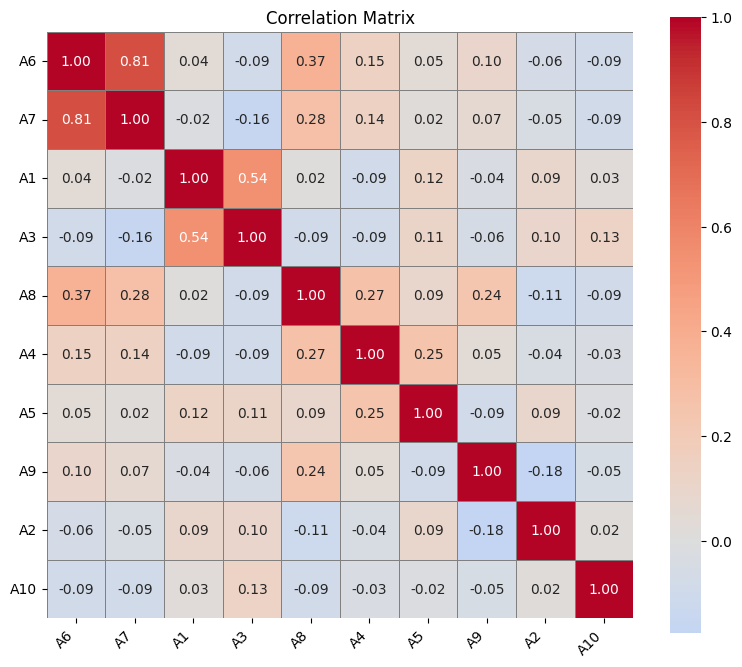

In [6]:
analyzer = CorrelationAnalyzer(main_df)
corr_df,corr_matrix = analyzer.correlation_matrix(num_method="pearson", cat_method="cramers_v",
                                      cat_num_method="correlation_ratio",return_matrix=True)

Visualisation.plot_heatmap_matrix(corr_matrix, title="Correlation Matrix")

CovarianceMatrix
----------------
A utility class for calculating the covariance matrix of asset returns,
optionally annualized. Intended for use in financial simulations such as
Monte Carlo modeling.

In [7]:
cov_calc = CovarianceMatrix(main_df)
cov_matrix = cov_calc.get_matrix()
# print(cov_matrix)

#### Cholesky Decomposition and Visualisation

We perform a Cholesky decomposition on the correlation matrix to obtain a lower triangular matrix.  
This decomposition is useful for simulations and generating correlated random variables.  
We then visualise the resulting matrix using a heatmap for better interpretation.

In [8]:
Decomposition_df = Decomposer.cholesky_decomposition(cov_matrix)
# Visualisation.plot_heatmap_matrix(Decomposition_df, title="Cholesky Decomposition Matrix")


##### 📊 Monte Carlo Simulation Using Rubinstein's Approach

In [9]:
# main_df = load_data(
#     source_type='csv',
#     input_path= os.path.join(os.getcwd(), "data/input/Monte Carlo Multivariable.csv"),
# )
main_df = load_data(
    source_type='csv',
    input_path= os.path.join(os.getcwd(), "data/input/Monte Carlo Univariable.csv"),
)

sim = MonteCarloSimulator(main_df,num_simulations=10000)
sim.run_simulation()
multivariate_MC_simulation = sim.get_final_simulated_values()
# covariance_matrix = sim.get_covariance_matrix()
raw_normal_simulation = sim.get_raw_simulations()
# cholesky_matrix = sim.get_cholesky_matrix()

save_util.save_dataframe_to_csv(
    multivariate_MC_simulation,
    os.path.join(os.getcwd(), "data/output/MonteCarlo final_sim_u.csv"),
    overwrite=True
    )

save_util.save_dataframe_to_csv(
    raw_normal_simulation,
    os.path.join(os.getcwd(), "data/output/MonteCarlo random_sim_u.csv"),
    overwrite=True
    )

# save_util.save_dataframe_to_csv(
#     covariance_matrix,
#     os.path.join(os.getcwd(), "data/output/MonteCarlo cov_matrix.csv"),
#     overwrite=True
#     )


# save_util.save_dataframe_to_csv(
#     cholesky_matrix,
#     os.path.join(os.getcwd(), "data/output/MonteCarlo cholesky_matrix.csv"),
#     overwrite=True
#     )

Data saved to c:\Data Science Projects\Daanish\projects\simulation\data/output/MonteCarlo final_sim_u.csv successfully.
Data saved to c:\Data Science Projects\Daanish\projects\simulation\data/output/MonteCarlo random_sim_u.csv successfully.


Reading From a Json Source

In [2]:
from utils.data_io import load_data
api_data = '[["name", "age"], ["Alice", 30], ["Bob", 25]]'
df = load_data(source_type='json', json_source=api_data)
print(df)

    name  age
0  Alice   30
1    Bob   25
